In [1]:
'''

load original df

'''

import pandas as pd
import os
import numpy as np
from scipy.stats import mannwhitneyu
import seaborn as sns
from statannotations.Annotator import Annotator
import warnings
warnings.filterwarnings('ignore') #supresses warnings for now
#warnings.filterwarnings(action='once') #shows warnings once

dataFilePath = os.path.join(os.getcwd(),'Data')

kicsSVdf = pd.read_csv(os.path.join(dataFilePath,'kics_structural_variations.txt'), sep = '\t', header = 0)
#kicsTEdf = pd.read_csv(os.path.join(dataFilePath,'kics_transposable_elements.txt'), sep = '\t', header = 0)
lfsSVdf = pd.read_csv(os.path.join(dataFilePath,'lfs_structural_variations.txt'), sep = '\t', header = 0)
#lfsTEdf = pd.read_csv(os.path.join(dataFilePath,'lfs_transposable_elements.txt'), sep = '\t', header = 0)
kicsClinicdf = pd.read_csv(os.path.join(dataFilePath,'kics_clinical_main.tsv'), sep = '\t', header = 0)
lfsClinicdf = pd.read_csv(os.path.join(dataFilePath,'lfs_clinical_main.tsv'), sep = '\t', header = 0)


In [2]:
"""

filter dfs

"""

sns.set(font_scale=1.5)


def maxGDAFFilter(colName: str, df: pd.DataFrame)->pd.DataFrame:
    temp = df[colName].str.contains(pat=',')
    Index = list(np.where(temp == True)[0])
    temp = df[colName].iloc[Index]
    tempIndex = temp.index

    for i in tempIndex:
        tempList = temp[i].split(',')
        tempList = [float(a) for a in tempList]
        maxTemp = max(tempList)
        df[colName][i] = maxTemp

    df[colName] = df[colName].astype('float64')
    
    return df
    
kicsSVdf = maxGDAFFilter('GD_AF', kicsSVdf)
lfsSVdf = maxGDAFFilter('GD_AF', lfsSVdf)

In [3]:
listValSearch = ['291775', '298313', '315666', '320118', '18_1907']
# searched for kID of 63, 83, 156, 171, 219
# kID 120 141 and 232 do not have any matches...
#what would make this that much better is if it was a dict. Computationally less heavy?

for i in listValSearch: 
    kicsSVdf.drop(kicsSVdf[kicsSVdf['sample_id'].str.contains(i)==True].index, inplace = True)


In [4]:
# #print(kicsSVdf['GD_AF'].astype(float))
# print(kicsSVdf.index)
# t = kicsSVdf.reset_index()
# print(t.columns)
# #contain_values = t[t['sample_id'].str.contains('MD')==True]
# #print(contain_values)


# #equal_values = t[t['sample_id']=='MD1399B1']
# print (equal_values)


kicsSVF = kicsSVdf.loc[(kicsSVdf['AnnotSV type'] == 'full') & (kicsSVdf['GD_AF'] < 0.01)]
lfsSVF = lfsSVdf.loc[(lfsSVdf['AnnotSV type'] == 'full') & (lfsSVdf['GD_AF'] < 0.01)]

kicsSVF['SV chrom'] = kicsSVF['SV chrom'].astype(str)
lfsSVF['SV chrom'] = lfsSVF['SV chrom'].astype(str)

kicsSVnum = kicsSVF['sample_id'].count()
lfsSVnum = lfsSVF['sample_id'].count()


#to improve this, multi-index would be good, that way we can have less columns
mergedSVdf = pd.DataFrame(data = {'kics':kicsSVF['SV type'], 'kChrom':kicsSVF['SV chrom'], 
                                  'kId':kicsSVF['sample_id'], 'lId':lfsSVF['sample_id'],
                                  'lfs':lfsSVF['SV type'], 'lChrom':lfsSVF['SV chrom']})


MannwhitneyuResult(statistic=30936618.5, pvalue=0.4991298095722455)


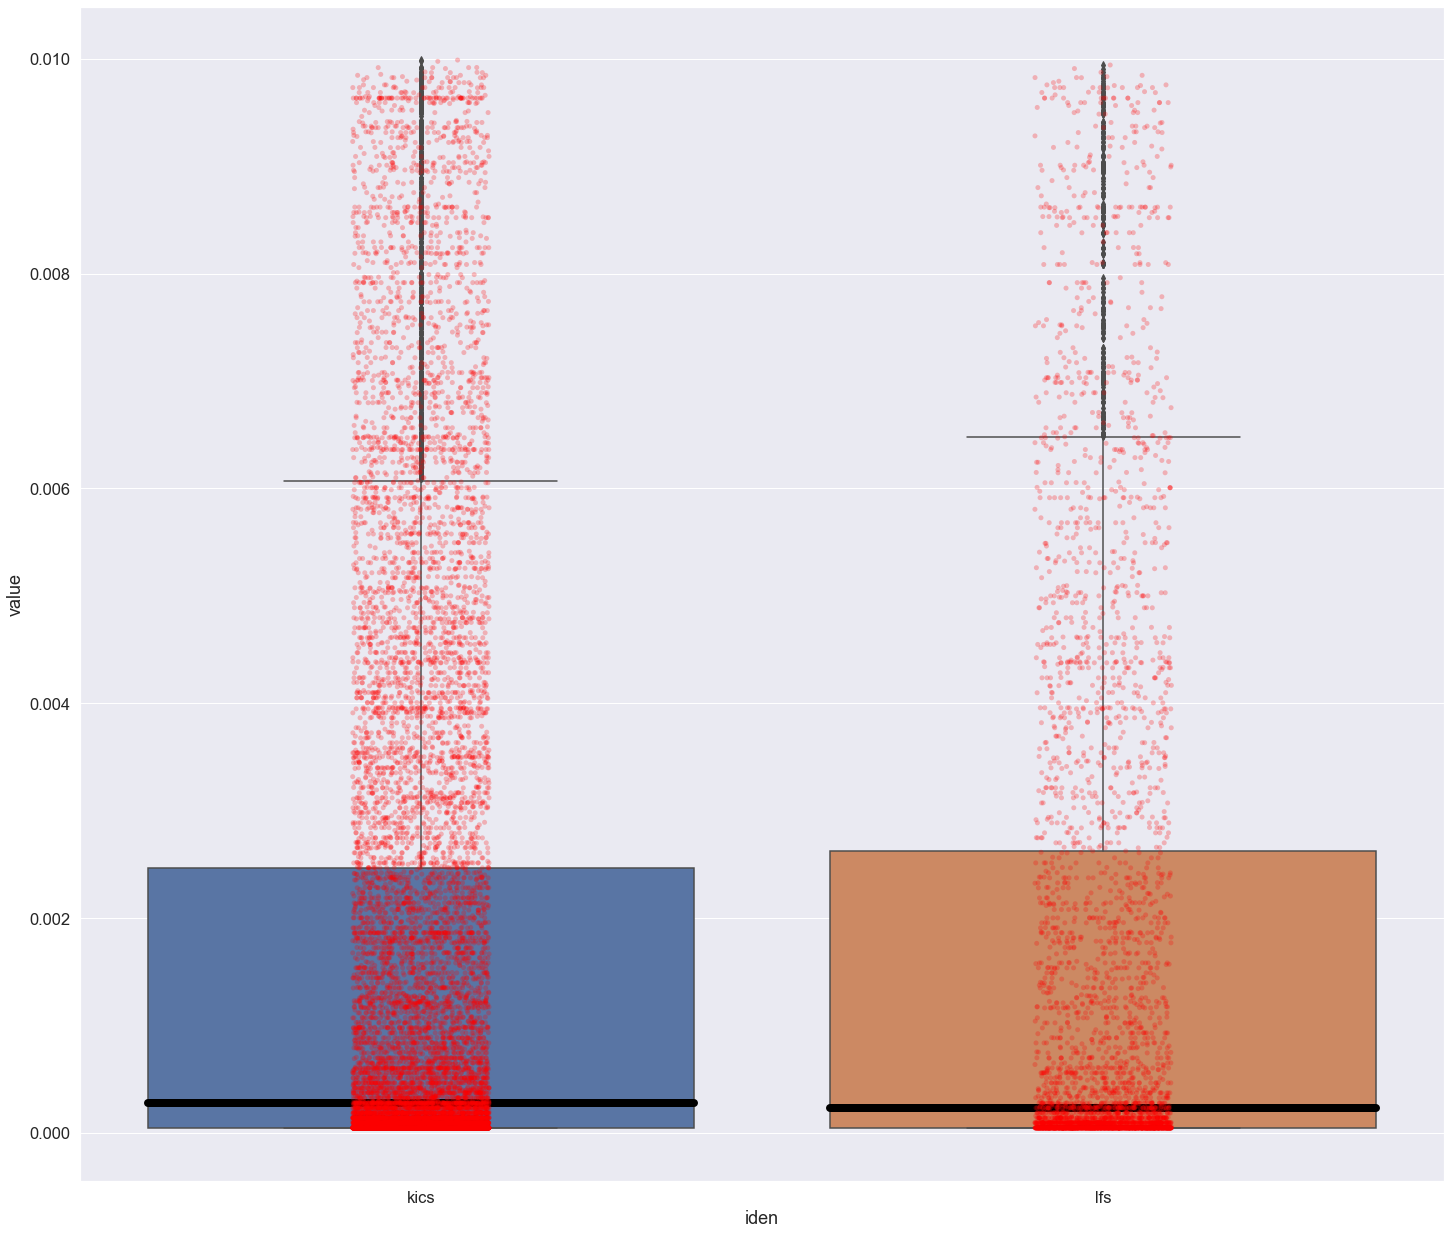

In [5]:
from matplotlib import pyplot as plt

mergedGDAF = pd.DataFrame(data = {'kics':kicsSVF['GD_AF'],
                                'lfs':lfsSVF['GD_AF']})

mergedGDAF.replace(to_replace = [-1], value = np.nan, inplace=True)
mergedGDAF.replace(to_replace = ['-1'], value = np.nan, inplace=True)


def boxplotPoints(title:list, column:list, df: pd.DataFrame , sizeH=20.50, sizeV=17.50, col='red', trans=0.25,outliers=True):
    plt.rcParams["figure.figsize"] = [sizeH, sizeV]
    plt.rcParams["figure.autolayout"] = True
    data = pd.DataFrame({
        t: df[c] for t,c in zip(title, column)})
    
    #print(data)
    plotTest = data
    plotTest = plotTest.stack().to_frame().reset_index().rename(columns={'level_1': 'iden', 0: 'value'}).drop('level_0', axis='columns')
    plotTest['cat'] = 1
    #print(plotTest.head(50))
    #data.boxplot()
    #BoxGraphMulti(plotTest, 'cat', 'value', 'iden')
    sns.boxplot(data=plotTest, x='iden', y='value', medianprops={"linewidth": 8, "color": 'black'},showfliers=outliers)
    
    #plot with boxplot
    if outliers:
        sns.stripplot(x = 'iden',
                  y = 'value',
                      color = 'red',
                      alpha = 0.25,
                  data = plotTest)

        list1 = df[column[0]].dropna()
        list2 = df[column[1]].dropna()
        print(mannwhitneyu(list1,list2))
        plt.show()

titles = ['kics','lfs']
columns = titles

boxplotPoints(titles, columns, mergedGDAF)


In [6]:
"""

1. Graph for frequency of SV types
2. Graphs for frequency of SV types specific to chromosomes

Function to graph bar graphs

"""

def BarGraphNormalized(label1: str, label2:str, df: pd.DataFrame, col1: str, col2: str,
                        xTitle: str, yTitle: str, divisor1: float, divisor2: float,
                        labels: list):
    #'kics', 'lfs', invdf, 'kchrom', 'lchrom', 'Chromosomes','Frequency','Graph2-INV',kicsSVnum, lfsSVnum

    title = label1 + " " + label2
    count1 = df[col1].value_counts()
    count2 = df[col2].value_counts()
    
    x_axis = np.arange(len(labels))
        
    for i in labels:
        if (not(i in count1)):
            add = pd.Series([0], index=[i])
            count1 = count1.append(add)
        if (not(i in count2)):
            add = pd.Series([0], index=[i])
            count2 = count2.append(add)
    
    plt.bar(x_axis - 0.2, [count1[a] for a in labels]/divisor1, 0.4, label = label1)
    plt.bar(x_axis + 0.2, [count2[a] for a in labels]/divisor2, 0.4, label = label2)

    plt.xticks(x_axis, labels)
    plt.xlabel(xTitle)
    plt.ylabel(yTitle)
    plt.title(title)
    plt.legend()
    plt.show()
    
xLabels = ['DEL','DUP','INV']
uniqueLabels = ['1','2','3','4','5','6','7','8','9','10',
                '11','12','13','14','15','16','17','18','19','20','21','22','X','Y']

deldf = mergedSVdf.loc[(mergedSVdf['kics'] == 'DEL') | (mergedSVdf['lfs']=='DEL')]
dupdf = mergedSVdf.loc[(mergedSVdf['kics'] == 'DUP') | (mergedSVdf['lfs']=='DUP')]
invdf = mergedSVdf.loc[(mergedSVdf['kics'] == 'INV') | (mergedSVdf['lfs']=='INV')]

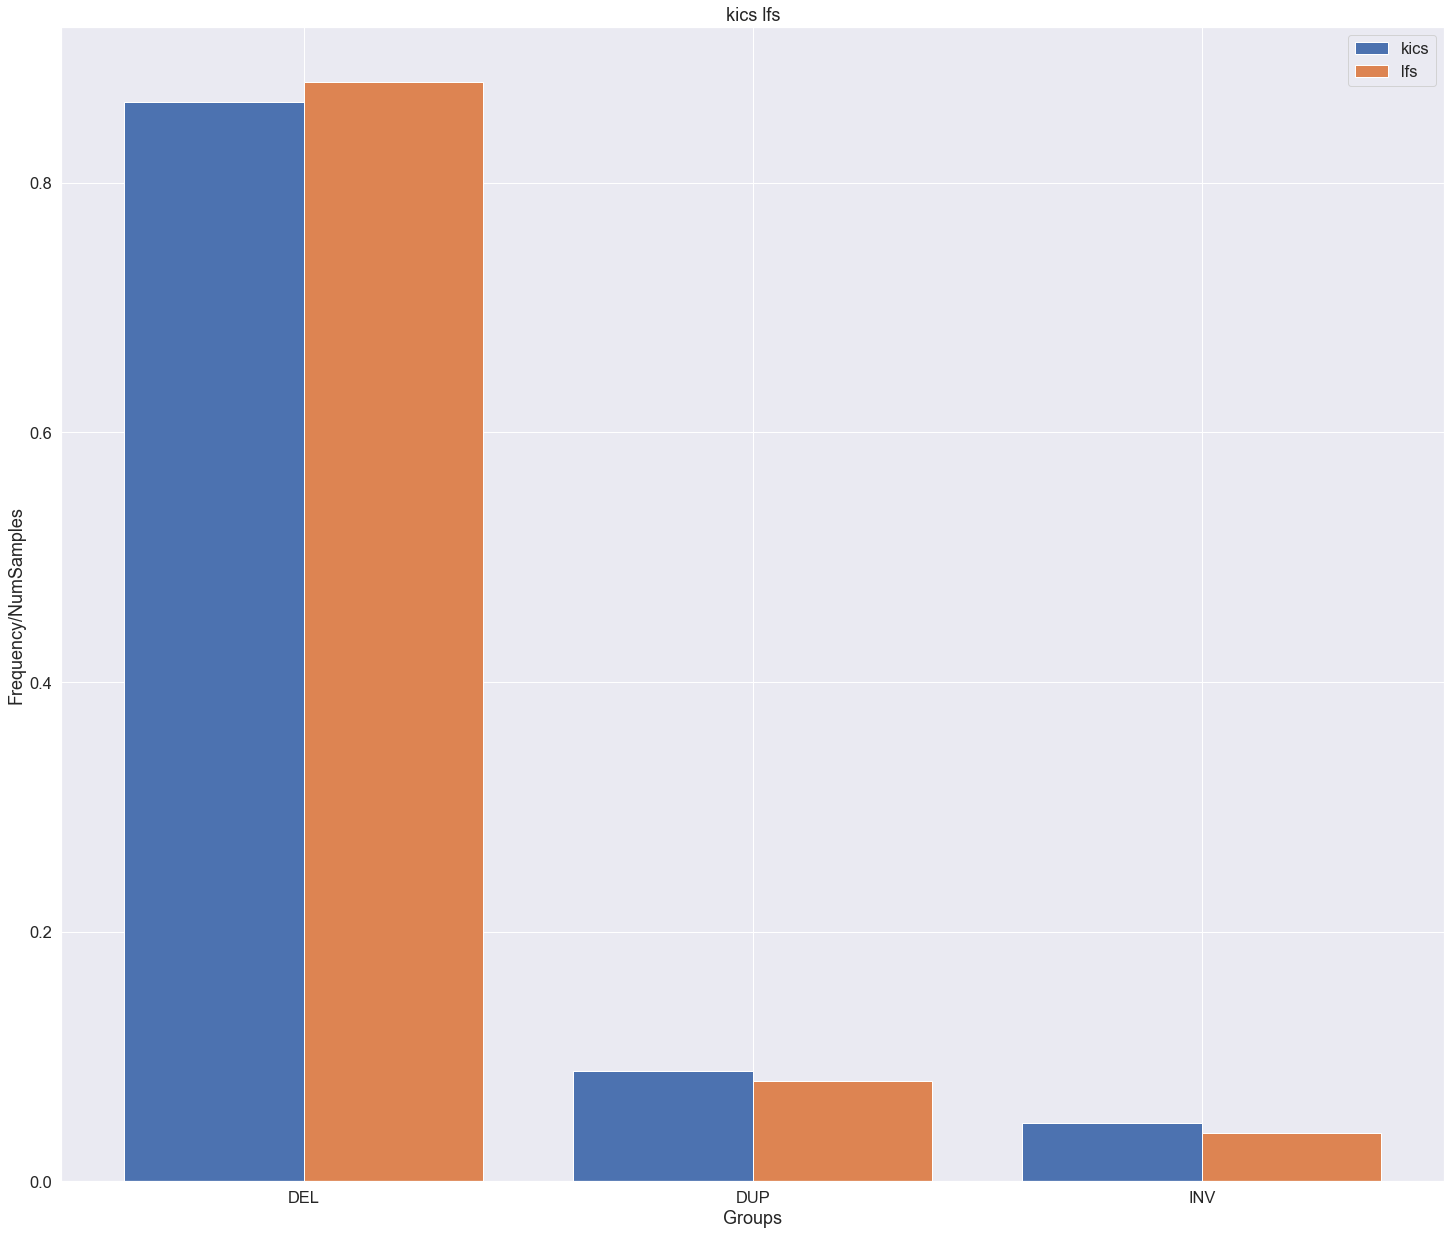

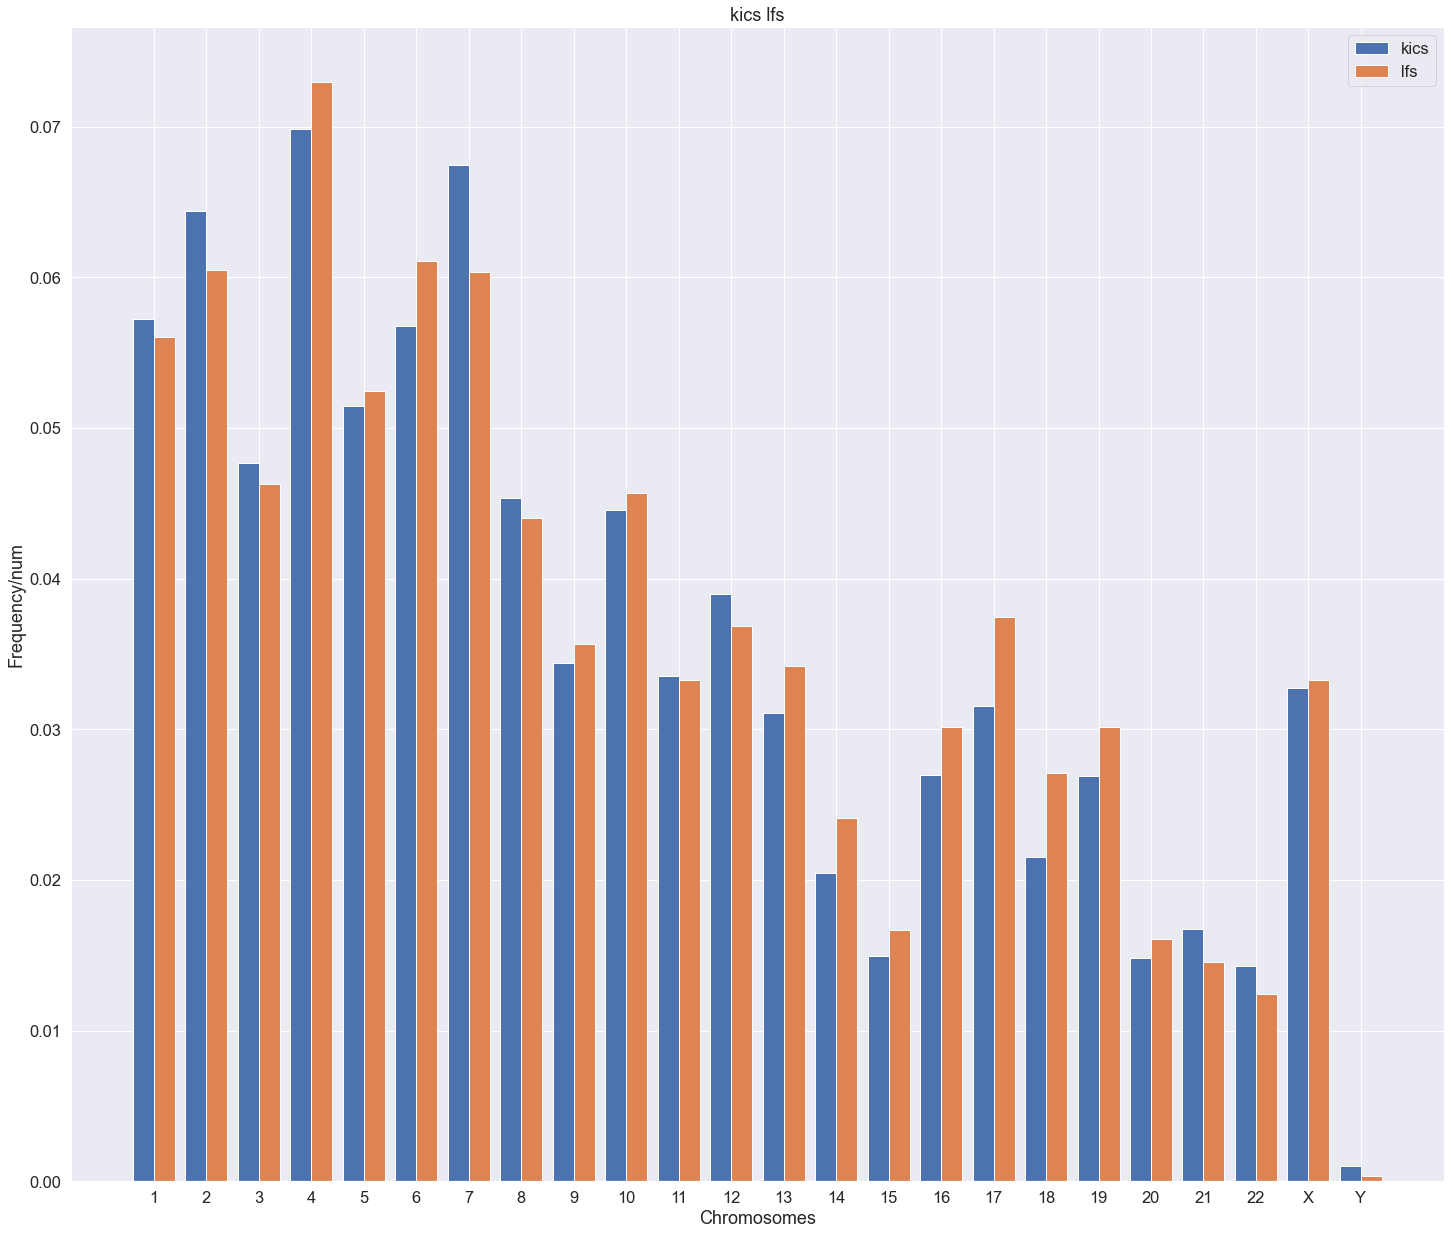

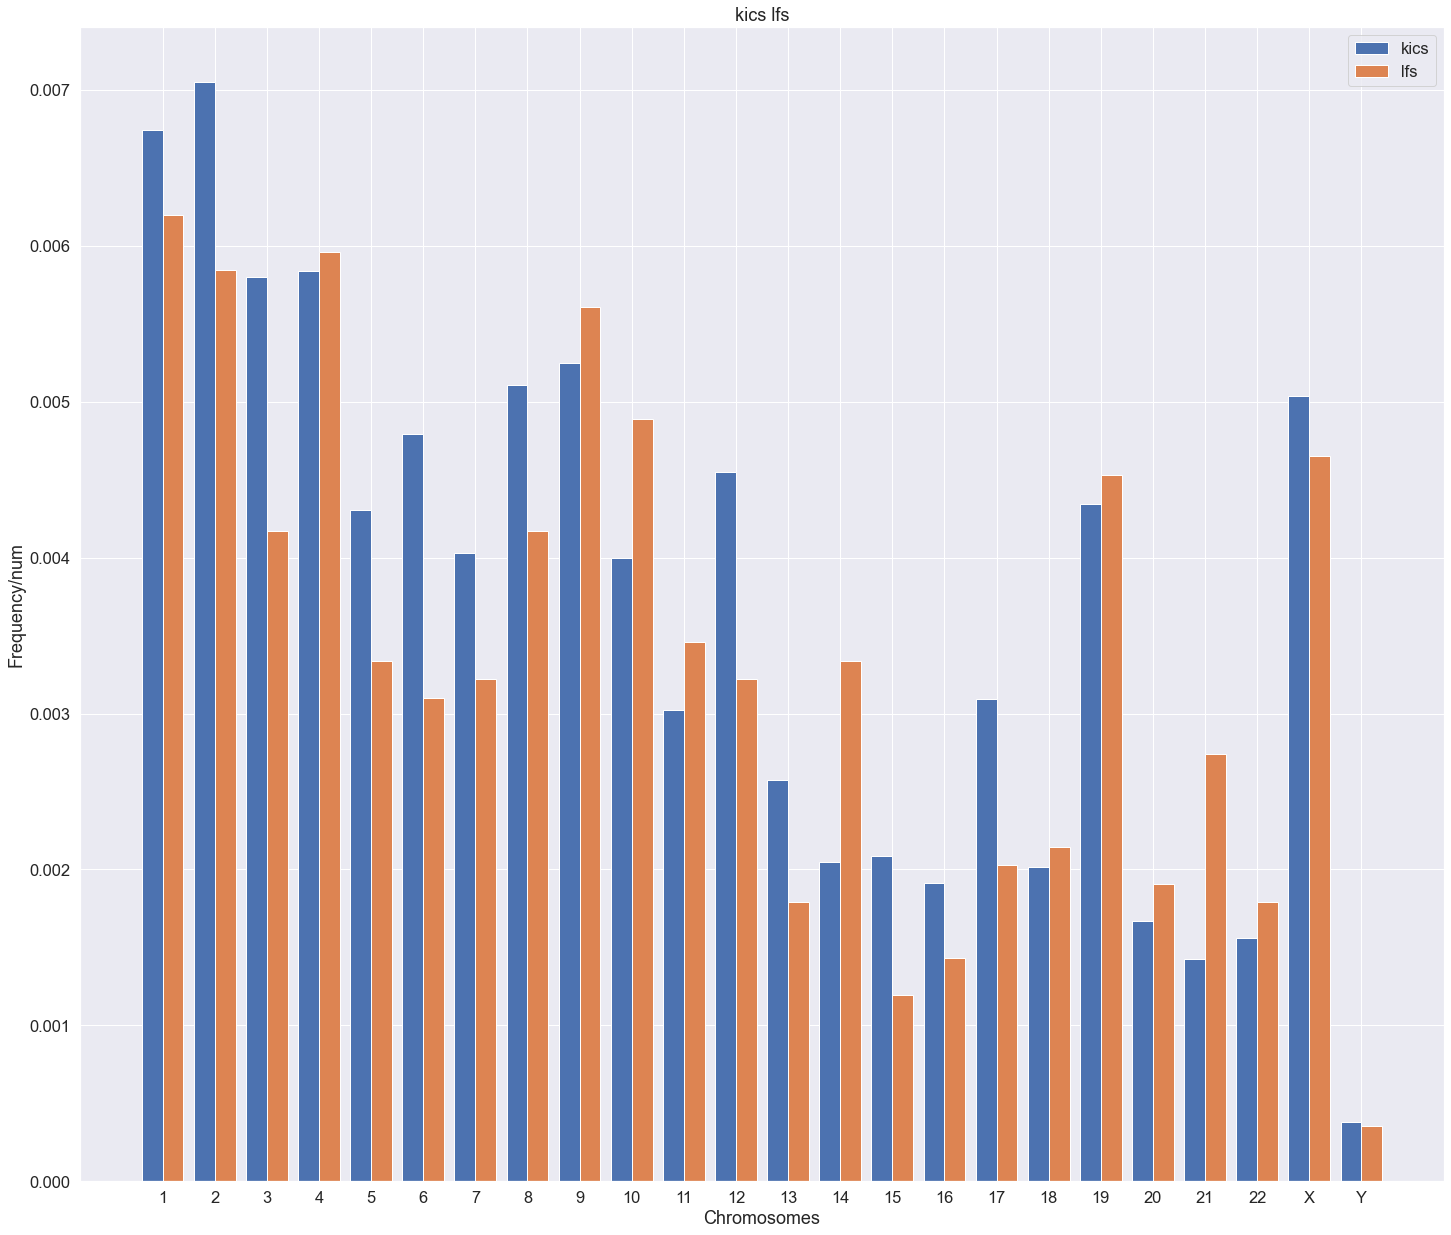

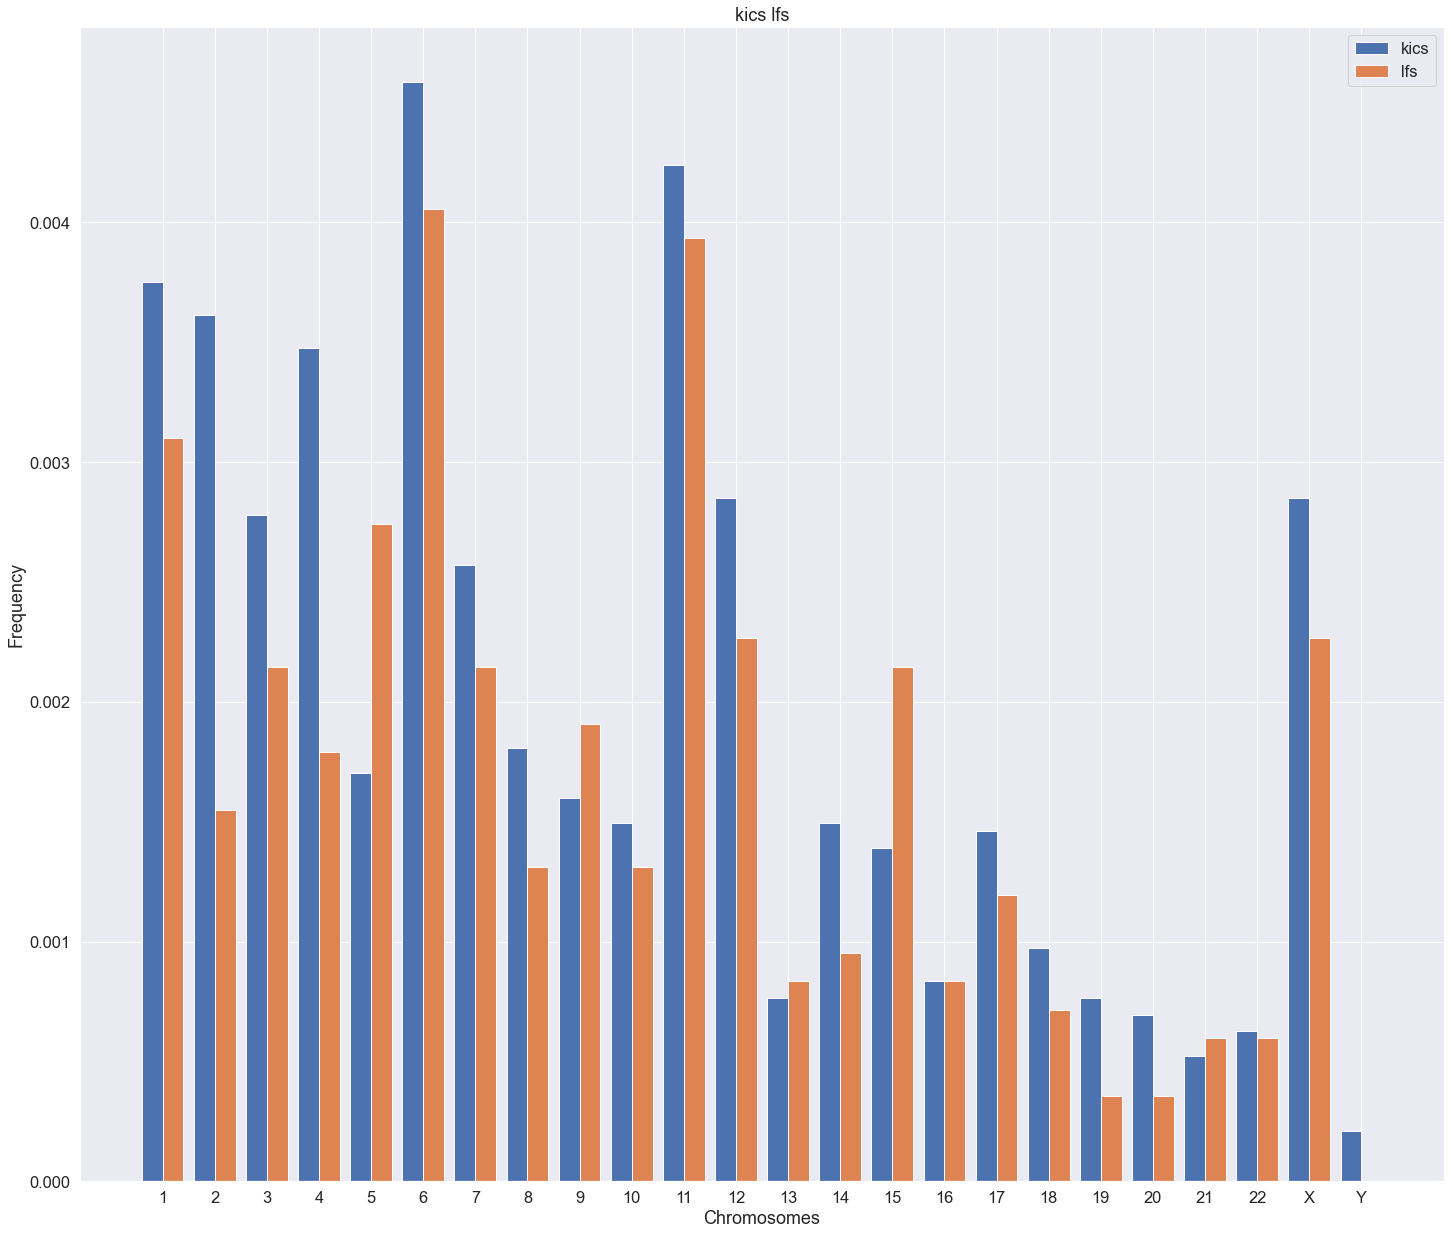

In [7]:
#Overall
BarGraphNormalized('kics', 'lfs', mergedSVdf, 'kics', 'lfs', 'Groups', 'Frequency/NumSamples', 
                   kicsSVnum, lfsSVnum, xLabels)

#Deletions 
BarGraphNormalized('kics', 'lfs', deldf, 'kChrom', 'lChrom', 'Chromosomes', 'Frequency/num', 
                   kicsSVnum, lfsSVnum, uniqueLabels)

#Duplicates
BarGraphNormalized('kics', 'lfs', dupdf, 'kChrom', 'lChrom', 'Chromosomes', 'Frequency/num', 
                   kicsSVnum, lfsSVnum, uniqueLabels)

#Inversions
BarGraphNormalized('kics', 'lfs', invdf, 'kChrom', 'lChrom', 'Chromosomes', 'Frequency', 
                   kicsSVnum, lfsSVnum, uniqueLabels)

In [8]:
"""

Testing group by

"""
#probably a better way to do this

kicsSVTypedf = pd.DataFrame(data = {'kics':kicsSVF['SV type'], 
                                  'kId':kicsSVF['sample_id']})
lfsSVTypedf = pd.DataFrame(data = {'lId':lfsSVF['sample_id'],
                                  'lfs':lfsSVF['SV type']})

#temp = mergedSVdf.groupby(['kId']).value_counts() #not sure how to use this, unsure if it's missing anything

##kics
ktemp = kicsSVTypedf.groupby(['kId']).value_counts()

##lfs
ltemp = lfsSVTypedf.groupby(['lId']).value_counts()

#print(ktemp.head(30))
#print(ktemp.index.get_level_values(0))

#get unique identifiers

uniqueK = kicsSVTypedf['kId'].unique()
uniqueL = lfsSVTypedf['lId'].unique()

#probably a better way, but itterate through the series and get the data 

def makeDataSet(identifiers, series: pd.Series, secondIndex: str)->list:
    
    dataList = []
    
    for i in identifiers:
        try:
            dataList.append(series[(i, secondIndex)])
        except:
            #pass
            dataList.append(0)

    return(dataList)


        
def makeUnequalDF(list1: list, list2: list) -> pd.DataFrame: #only for kics vs lfs D:
    tempDict = dict(kics = list1, lfs = list2)
    df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in tempDict.items()]))
    return df

# SV Type

In [9]:
kDelData = makeDataSet(uniqueK, ktemp, 'DEL')
lDelData = makeDataSet(uniqueL, ltemp, 'DEL')
tempDelDF = makeUnequalDF(kDelData, lDelData)

kDupData = makeDataSet(uniqueK, ktemp, 'DUP')
lDupData = makeDataSet(uniqueL, ltemp, 'DUP')
tempDupDF = makeUnequalDF(kDupData, lDupData)

kInvData = makeDataSet(uniqueK, ktemp, 'INV')
lInvData = makeDataSet(uniqueL, ltemp, 'INV')
tempInvDF = makeUnequalDF(kInvData, lInvData)

## Del 

MannwhitneyuResult(statistic=11853.5, pvalue=0.011881811050079119)


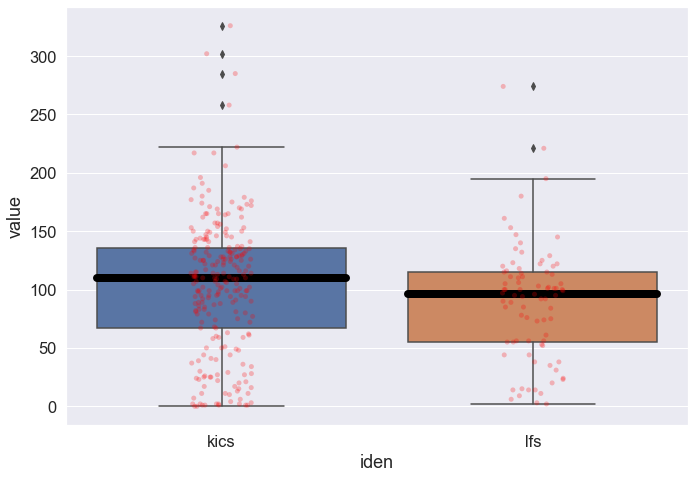

In [10]:
boxplotPoints(titles, columns, tempDelDF, 10, 7)

## Dup 

MannwhitneyuResult(statistic=12426.0, pvalue=0.0009697425806146196)


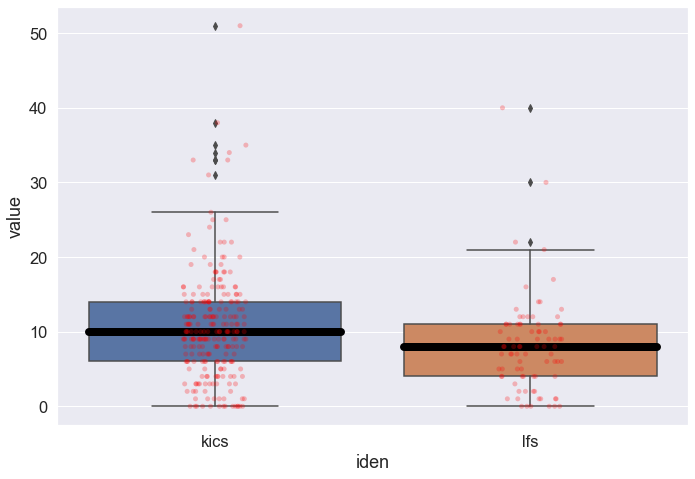

In [11]:
boxplotPoints(titles, columns, tempDupDF, 10, 7)

## Inv 

MannwhitneyuResult(statistic=12554.0, pvalue=0.000498224722188963)


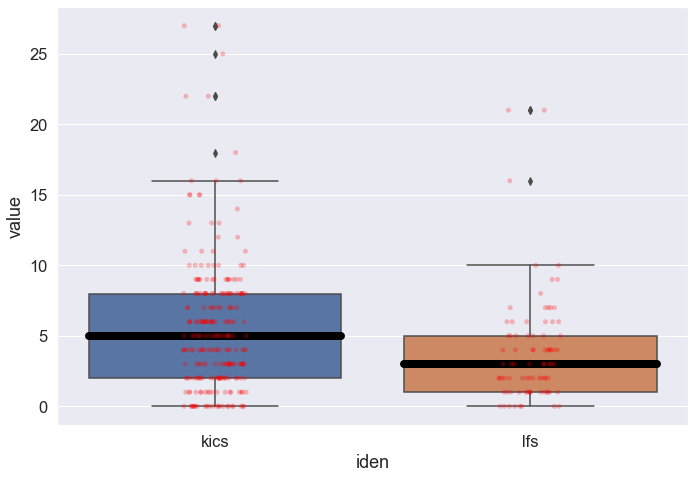

In [12]:
boxplotPoints(titles, columns, tempInvDF, 10, 7)

In [13]:
"""

Chromosome Specific
Cleaned up

"""

def formatDataFrame(df: pd.DataFrame, groupByList: list, normalizeList: list, 
                    iterateList: list, labels: list, typeSV: str ) -> tuple:
    
    #kicsMore, lfsMore, ['id','SV','chrom'], nomBPChrom, 

    dfGrouped = df.groupby(groupByList).size().unstack(fill_value=0)
    print(dfGrouped)
    dfReg = pd.DataFrame()
    dfNorm = pd.DataFrame()
    df1WC = pd.DataFrame()
    df2WC = pd.DataFrame()
    
    for i in iterateList:
        tempList = []
        
        try:
            series = dfGrouped.loc[(i,typeSV)]
            #print(series)
            
        except:
            series = pd.Series(0, index=labels)
            
        for j,div in zip(labels, normalizeList):
            tempList.append(series[j]/div)
            
        d = {'chrom':labels, 'normalized':tempList}
        tempdf = pd.DataFrame(d)

        dfNorm = pd.concat([dfNorm, tempdf], axis=0)
        dfReg = pd.concat([dfReg, series], axis=0) 
    
    return(dfReg, dfNorm)

def BoxGraphMulti(df: pd.DataFrame, xCol, yCol, compCol):
    orderList = ['1','2','3','4','5','6','7','8','9','10',
                '11','12','13','14','15','16','17','18','19','20','21','22','X','Y']
    ax = sns.boxplot(data=df, x=xCol, y=yCol, hue=compCol, medianprops={"linewidth": 8, 'color':'black'},
                order=orderList)
    
    listPairing = []
    #pairings for multi correction
    for i in orderList:
        p1 = (i, 'kics')
        p2 = (i, 'lfs')
        p = (p1,p2)
        listPairing.append(p)
        
    annot = Annotator(ax, listPairing, data=df, x=xCol, y=yCol, hue=compCol,order=orderList)
    annot.configure(test='Mann-Whitney', comparisons_correction='BH',correction_format='replace',
                    text_format='star', loc='outside', verbose=2)
    annot.apply_and_annotate()

    plt.show()
    
    


kicsMore = pd.DataFrame(data = {'SV':kicsSVF['SV type'], 'chrom':kicsSVF['SV chrom'], 
                                  'id':kicsSVF['sample_id']})
lfsMore = pd.DataFrame(data = {'id':lfsSVF['sample_id'], 'chrom':lfsSVF['SV chrom'],
                                  'SV':lfsSVF['SV type']})

numBPChrom = [249250621, 243199373, 198022430, 191154276, 180915260, 
              171115067, 159138663, 146364022, 141213431, 135534747,
              135006516, 133851895, 115169878, 107349540, 102531392,
              90354753, 81195210, 78077248, 59128983, 63025520,
              48129895, 51304566, 155270560, 59373566]

grouping = ['id', 'SV', 'chrom']


'''
If you have time, you should make it so that the plot can have the points showing/scattered plot
'''


'\nIf you have time, you should make it so that the plot can have the points showing/scattered plot\n'

chrom            1  10  11  12  13  14  15  16  17  18  ...  22   3   4  5  \
id         SV                                           ...                  
5510       DEL   3   6   2   5   2   2   3   3   3   4  ...   3   3   7  7   
           DUP   0   1   0   0   0   0   0   0   1   0  ...   0   0   1  1   
           INV   2   0   1   0   0   0   0   0   0   0  ...   0   0   1  0   
5511       DEL   8   5   2   8   6   3   3   6   3   3  ...   4   6   7  8   
           DUP   1   1   1   1   0   1   0   1   0   0  ...   0   1   1  0   
...             ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  .. ..   
N_-_318953 DUP   0   1   2   0   0   1   0   1   0   1  ...   0   1   0  0   
           INV   0   0   1   0   0   0   0   0   0   2  ...   0   0   0  0   
N_-_333809 DEL  13   9   2   4   3   0   4   6   4   0  ...   3  11  10  0   
           DUP   1   0   0   1   2   1   0   0   0   1  ...   0   0   3  3   
           INV   0   0   0   0   0   0   0   0   0   0  ...   0 

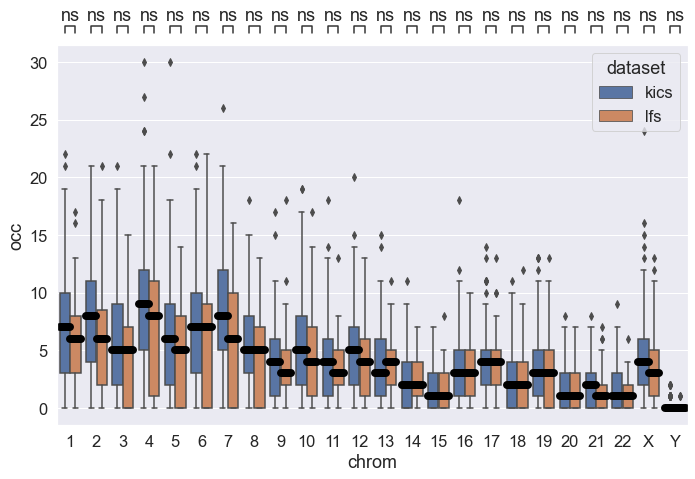

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10_kics vs. 10_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.820e-01 U_stat=1.098e+04
11_kics vs. 11_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.229e-01 U_stat=1.072e+04
12_kics vs. 12_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.687e-02 (ns) U_stat=1.162e+04
13_kics vs. 13_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.774e-01 U_stat=1.021e+04
14_kics vs. 14_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.091e-01 U_stat=9.730e+03
15_kics vs. 15_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.006e-01 U_stat=1.028e+04
16_kics vs. 16_lfs: Mann-Whitney-Wilcoxon test two-sided w

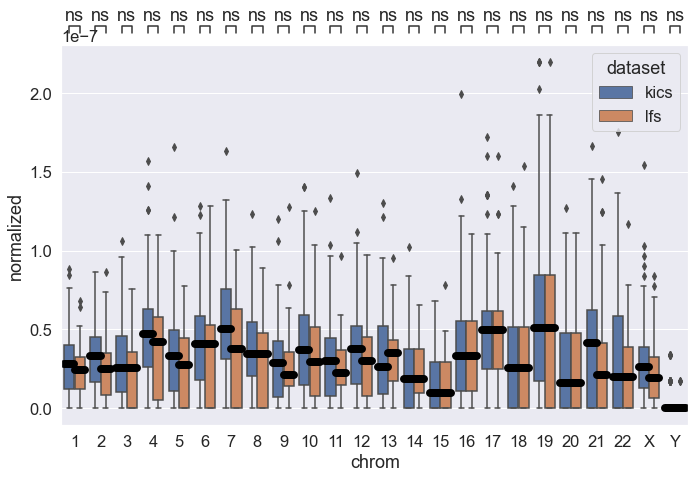

In [14]:
"""
Normalised and Regular Graph
"""

#rename things later and put into function/i but this is the statistical test T-T
dog = kicsMore.groupby(grouping).size().unstack(fill_value=0)
dog = dog.stack().unstack(1)
#print(type(dog))
dog = dog.drop(['DUP','INV'], axis=1)
dog = dog.stack().unstack(1)

#print(dog)

cat = lfsMore.groupby(grouping).size().unstack(fill_value=0)
cat = cat.stack().unstack(1)
#print(type(dog))
cat = cat.drop(['DUP','INV'], axis=1)
cat = cat.stack().unstack(1)


    #print(mannwhitneyu(dog[i].values, cat[i].values))


newKdf, normKdf = formatDataFrame(kicsMore, grouping, numBPChrom, uniqueK, uniqueLabels, 'DEL')
#print(newKdf)

newLdf, normLdf = formatDataFrame(lfsMore, grouping, numBPChrom, uniqueL, uniqueLabels, 'DEL')

# for i in uniqueLabels:
#     print(i)
#     dog = normKdf.loc[normKdf['chrom'] == i]
#     list1 = dog['normalized'].tolist()
#     cat = normLdf.loc[normLdf['chrom'] == i]
#     list2 = cat['normalized'].tolist()
#     print(mannwhitneyu(list1, list2))

#print(newKdf.index)
#print(newKdf.pivot( columns='index', values=0))

newKdf['dataset'] = 'kics'
newLdf['dataset'] = 'lfs'
normKdf['dataset'] = 'kics'
normLdf['dataset'] = 'lfs'

newMergedDf = pd.concat([newKdf, newLdf])
print(newMergedDf)
newMergedDf.rename(columns = {0:'occ'}, inplace = True)
newMergedDf.reset_index(inplace=True)
newMergedDf.rename(columns = {'index':'chrom'}, inplace = True)

BoxGraphMulti(newMergedDf, 'chrom', 'occ', 'dataset')

normMergedDf = pd.concat([normKdf, normLdf])
normMergedDf.reset_index(inplace=True)

BoxGraphMulti(normMergedDf, 'chrom', 'normalized', 'dataset')

In [15]:
"""

Dup

"""
newKdf, normKdf = formatDataFrame(kicsMore, grouping, numBPChrom, uniqueK, uniqueLabels, 'DUP')
newLdf, normLdf = formatDataFrame(lfsMore, grouping, numBPChrom, uniqueL, uniqueLabels, 'DUP')

# for i in uniqueLabels:
#     print(i)
#     dog = normKdf.loc[normKdf['chrom'] == i]
#     list1 = dog['normalized'].tolist()
#     cat = normLdf.loc[normLdf['chrom'] == i]
#     list2 = cat['normalized'].tolist()
#     print(mannwhitneyu(list1, list2))

newKdf['dataset'] = 'kics'
newLdf['dataset'] = 'lfs'
normKdf['dataset'] = 'kics'
normLdf['dataset'] = 'lfs'

newMergedDf = pd.concat([newKdf, newLdf])
newMergedDf.rename(columns = {0:'occ'}, inplace = True)
newMergedDf.reset_index(inplace=True)
newMergedDf.rename(columns = {'index':'chrom'}, inplace = True)

normMergedDf = pd.concat([normKdf, normLdf])
normMergedDf.reset_index(inplace=True)

chrom            1  10  11  12  13  14  15  16  17  18  ...  22   3   4  5  \
id         SV                                           ...                  
5510       DEL   3   6   2   5   2   2   3   3   3   4  ...   3   3   7  7   
           DUP   0   1   0   0   0   0   0   0   1   0  ...   0   0   1  1   
           INV   2   0   1   0   0   0   0   0   0   0  ...   0   0   1  0   
5511       DEL   8   5   2   8   6   3   3   6   3   3  ...   4   6   7  8   
           DUP   1   1   1   1   0   1   0   1   0   0  ...   0   1   1  0   
...             ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  .. ..   
N_-_318953 DUP   0   1   2   0   0   1   0   1   0   1  ...   0   1   0  0   
           INV   0   0   1   0   0   0   0   0   0   2  ...   0   0   0  0   
N_-_333809 DEL  13   9   2   4   3   0   4   6   4   0  ...   3  11  10  0   
           DUP   1   0   0   1   2   1   0   0   0   1  ...   0   0   3  3   
           INV   0   0   0   0   0   0   0   0   0   0  ...   0 

## Duplication

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10_kics vs. 10_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.166e-01 U_stat=1.007e+04
11_kics vs. 11_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.852e-01 U_stat=9.772e+03
12_kics vs. 12_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.180e-02 (ns) U_stat=1.134e+04
13_kics vs. 13_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.542e-01 U_stat=1.076e+04
14_kics vs. 14_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.578e-01 U_stat=9.600e+03
15_kics vs. 15_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.355e-02 (ns) U_stat=1.099e+04
16_kics vs. 16_lfs: Mann-Whitney-Wilcoxon test two-si

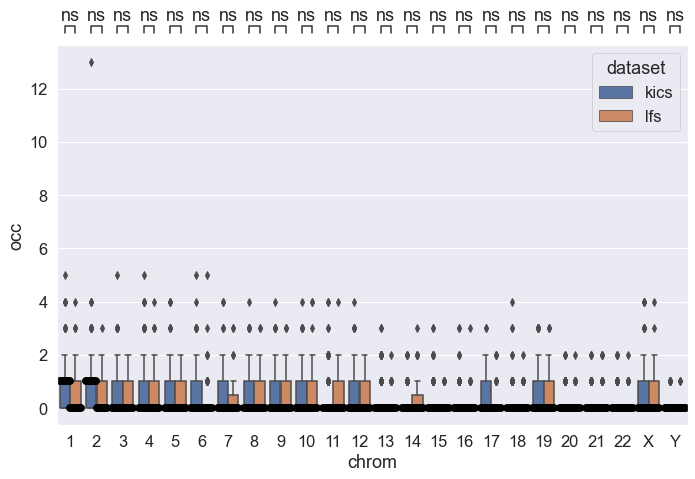

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10_kics vs. 10_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.166e-01 U_stat=1.007e+04
11_kics vs. 11_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.852e-01 U_stat=9.772e+03
12_kics vs. 12_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.180e-02 (ns) U_stat=1.134e+04
13_kics vs. 13_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.542e-01 U_stat=1.076e+04
14_kics vs. 14_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.578e-01 U_stat=9.600e+03
15_kics vs. 15_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.355e-02 (ns) U_stat=1.099e+04
16_kics vs. 16_lfs: Mann-Whitney-Wilcoxon test two-si

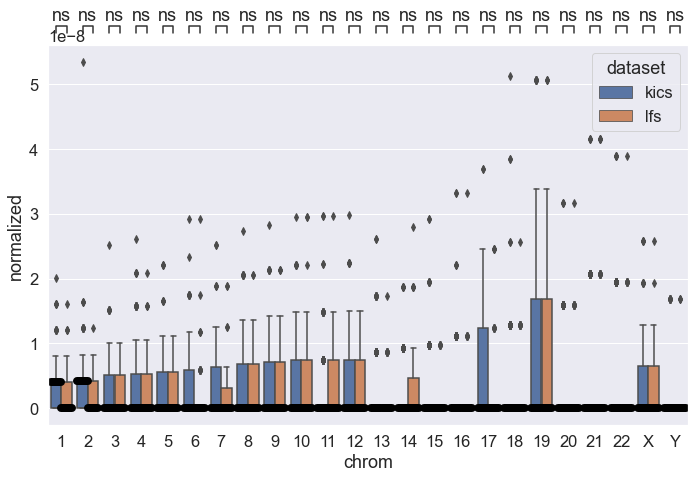

In [16]:
BoxGraphMulti(newMergedDf, 'chrom', 'occ', 'dataset')

BoxGraphMulti(normMergedDf, 'chrom', 'normalized', 'dataset')

In [17]:
"""

INV

"""

newKdf, normKdf = formatDataFrame(kicsMore, grouping, numBPChrom, uniqueK, uniqueLabels, 'INV')
newLdf, normLdf = formatDataFrame(lfsMore, grouping, numBPChrom, uniqueL, uniqueLabels, 'INV')

# for i in uniqueLabels:
#     print(i)
#     dog = normKdf.loc[normKdf['chrom'] == i]
#     list1 = dog['normalized'].tolist()
#     cat = normLdf.loc[normLdf['chrom'] == i]
#     list2 = cat['normalized'].tolist()
#     print(mannwhitneyu(list1, list2))

newKdf['dataset'] = 'kics'
newLdf['dataset'] = 'lfs'
normKdf['dataset'] = 'kics'
normLdf['dataset'] = 'lfs'

newMergedDf = pd.concat([newKdf, newLdf])
newMergedDf.rename(columns = {0:'occ'}, inplace = True)
newMergedDf.reset_index(inplace=True)
newMergedDf.rename(columns = {'index':'chrom'}, inplace = True)

normMergedDf = pd.concat([normKdf, normLdf])
normMergedDf.reset_index(inplace=True)

chrom            1  10  11  12  13  14  15  16  17  18  ...  22   3   4  5  \
id         SV                                           ...                  
5510       DEL   3   6   2   5   2   2   3   3   3   4  ...   3   3   7  7   
           DUP   0   1   0   0   0   0   0   0   1   0  ...   0   0   1  1   
           INV   2   0   1   0   0   0   0   0   0   0  ...   0   0   1  0   
5511       DEL   8   5   2   8   6   3   3   6   3   3  ...   4   6   7  8   
           DUP   1   1   1   1   0   1   0   1   0   0  ...   0   1   1  0   
...             ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  .. ..   
N_-_318953 DUP   0   1   2   0   0   1   0   1   0   1  ...   0   1   0  0   
           INV   0   0   1   0   0   0   0   0   0   2  ...   0   0   0  0   
N_-_333809 DEL  13   9   2   4   3   0   4   6   4   0  ...   3  11  10  0   
           DUP   1   0   0   1   2   1   0   0   0   1  ...   0   0   3  3   
           INV   0   0   0   0   0   0   0   0   0   0  ...   0 

### Inversion

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10_kics vs. 10_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.102e-01 U_stat=1.071e+04
11_kics vs. 11_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.181e-01 U_stat=1.078e+04
12_kics vs. 12_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.325e-02 U_stat=1.094e+04
13_kics vs. 13_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.016e-01 U_stat=9.916e+03
14_kics vs. 14_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.556e-01 U_stat=1.063e+04
15_kics vs. 15_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.778e-01 U_stat=9.661e+03
16_kics vs. 16_lfs: Mann-Whitney-Wilcoxon test two-sided with B

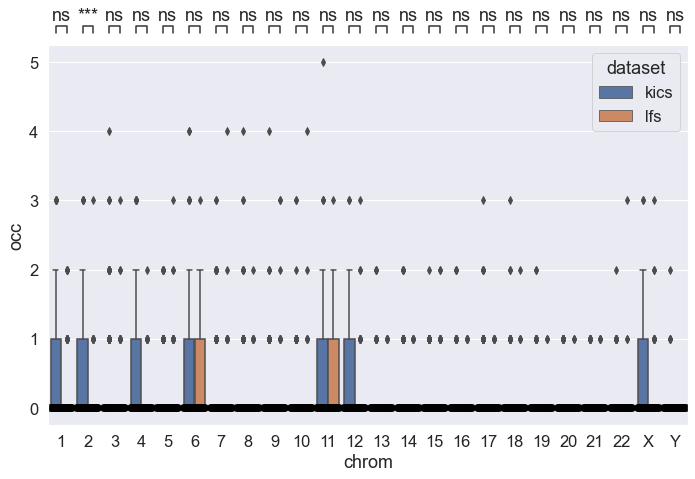

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10_kics vs. 10_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.102e-01 U_stat=1.071e+04
11_kics vs. 11_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.181e-01 U_stat=1.078e+04
12_kics vs. 12_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.325e-02 U_stat=1.094e+04
13_kics vs. 13_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.016e-01 U_stat=9.916e+03
14_kics vs. 14_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.556e-01 U_stat=1.063e+04
15_kics vs. 15_lfs: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.778e-01 U_stat=9.661e+03
16_kics vs. 16_lfs: Mann-Whitney-Wilcoxon test two-sided with B

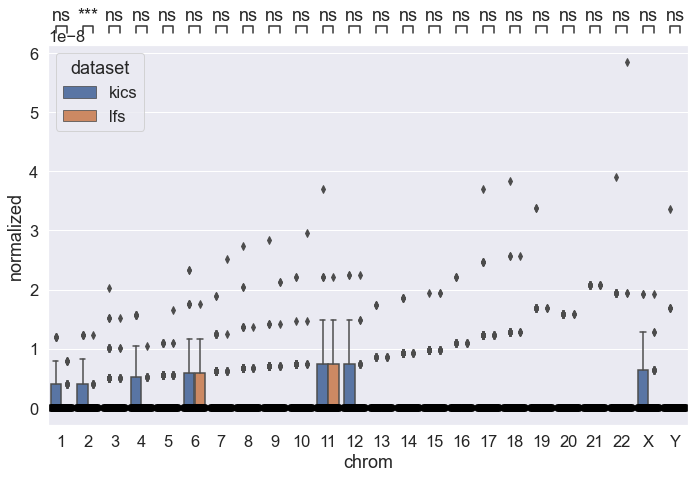

In [18]:
BoxGraphMulti(newMergedDf, 'chrom', 'occ', 'dataset')
BoxGraphMulti(normMergedDf, 'chrom', 'normalized', 'dataset')

MannwhitneyuResult(statistic=239045793099.5, pvalue=0.3996746287296191)


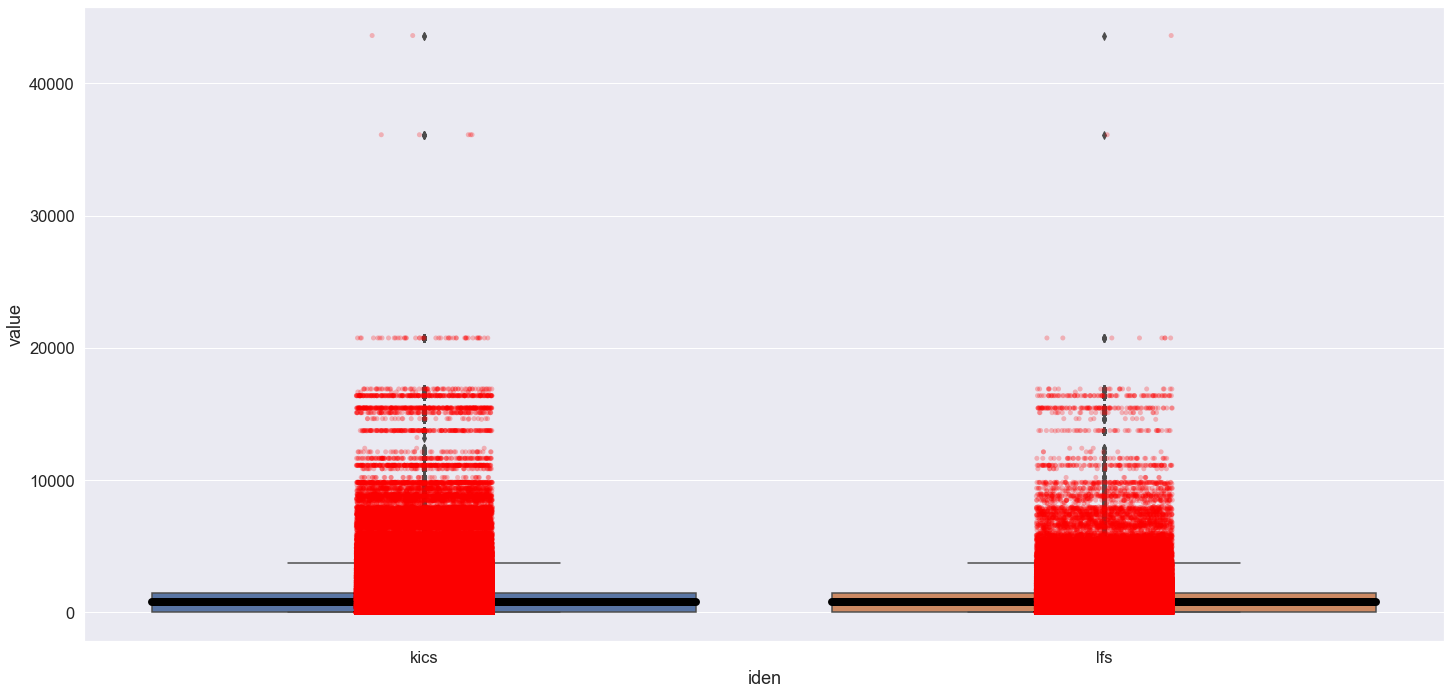

In [19]:
""" filter the df for CDS_length """

kicsSVR = kicsSVdf.loc[(kicsSVdf['AnnotSV type'] == 'split')& (kicsSVdf['GD_AF'] < 0.01) & (kicsSVdf['GD_AF'] >=0)] 
lfsSVR = lfsSVdf.loc[(lfsSVdf['AnnotSV type'] == 'split') & (lfsSVdf['GD_AF'] < 0.01) & (lfsSVdf['GD_AF'] >=0)]


mergedCDSdf = pd.DataFrame(data = {'kics':kicsSVR['CDS length'], 'lfs':lfsSVR['CDS length']})
boxplotPoints(titles, columns, mergedCDSdf, sizeV = 10)
#print(mergedCDSdf.head(50)) #they look the same